In [1]:
from IPython.display import Image

In [2]:
!python sklearn_alone.py

gp - sklearn ( 1 ):  GaussianProcessRegressor(alpha=0.0,
                         kernel=1**2 * RBF(length_scale=100) + WhiteKernel(noise_level=1)) 
kernel: 0.00316**2 * RBF(length_scale=109) + WhiteKernel(noise_level=0.637)
theta: [-11.51292546   4.69457218  -0.45065571] [1.00000000e-05 1.09352016e+02 6.37210191e-01]
likelihood: -23.87233736198489
gp - sklearn ( 2 ):  GaussianProcessRegressor(alpha=0.0,
                         kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05)) 
kernel: 0.64**2 * RBF(length_scale=0.365) + WhiteKernel(noise_level=0.294)
theta: [-0.89336431 -1.00663819 -1.22409422] [0.4092765  0.36544547 0.2940239 ]
likelihood: -21.80509089016203
0.00316**2 * RBF(length_scale=109) + WhiteKernel(noise_level=0.637)
0.64**2 * RBF(length_scale=0.365) + WhiteKernel(noise_level=0.294)


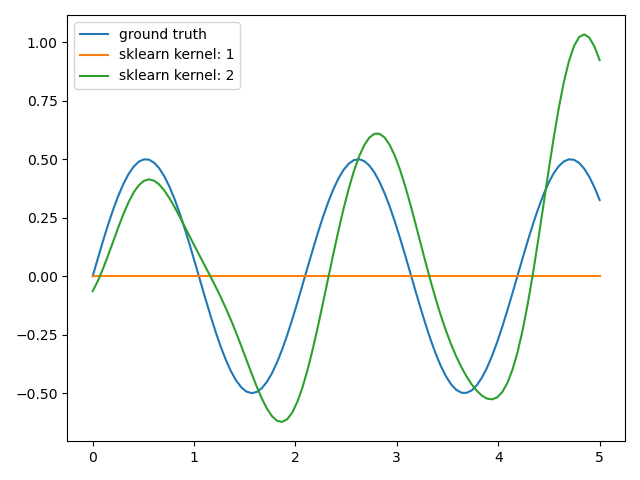

In [3]:
Image(filename='plots/sklearn_kernel.png') 

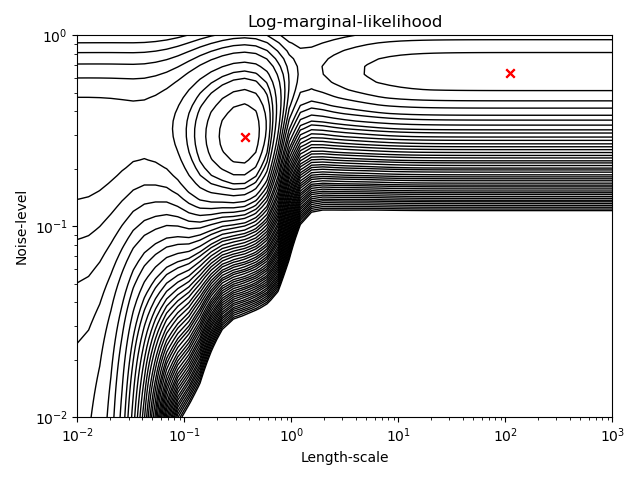

In [4]:
Image(filename='plots/sklearn_lml.png') 

In [5]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
# declare that we should use my fitting method
from fit import fit
GaussianProcessRegressor.fit = fit
# generate data exactly as in the example
rng = np.random.RandomState(0)
X = rng.uniform(0, 5, 20)[:, np.newaxis]
y = 0.5 * np.sin(3 * X[:, 0]) + rng.normal(0, 0.5, X.shape[0])
print('HGDL -----------------------------------------------------------')
kernel1 = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
kernel2 = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))

GPs = GaussianProcessRegressor(kernel=kernel2, alpha=0.0, optimizer='hgdl', random_state=42).fit(
    X, y, num_individuals=5, num_epochs=1, max_local=1)

for i, gp in enumerate(GPs):
    print('gp - HGDL (',i+1,'): ', gp, '\nkernel:', gp.kernel_)
    print('theta:', gp.kernel_.theta, np.exp(gp.kernel_.theta))
    print('likelihood:', gp.log_marginal_likelihood_value_)


HGDL -----------------------------------------------------------
gp - HGDL ( 1 ):  GaussianProcessRegressor(alpha=0.0,
                         kernel=0.64**2 * RBF(length_scale=0.365) + WhiteKernel(noise_level=0.294),
                         random_state=42) 
kernel: 0.64**2 * RBF(length_scale=0.365) + WhiteKernel(noise_level=0.294)
theta: [-0.89335213 -1.00663432 -1.2240949 ] [0.40928149 0.36544689 0.2940237 ]
likelihood: -21.805090890140278


In [6]:
import numpy as np

In [7]:
import matplotlib.pyplot as plt

In [8]:
from matplotlib.colors import LogNorm

In [9]:
rng = np.random.RandomState(0)
X = rng.uniform(0, 5, 20)[:, np.newaxis]
y = 0.5 * np.sin(3 * X[:, 0]) + rng.normal(0, 0.5, X.shape[0])
X_ = np.linspace(0, 5, 100)

In [10]:
GPs

[GaussianProcessRegressor(alpha=0.0,
                          kernel=0.64**2 * RBF(length_scale=0.365) + WhiteKernel(noise_level=0.294),
                          random_state=42)]

In [11]:
# GPs = GPs[:2] + GPs[3:]

In [12]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

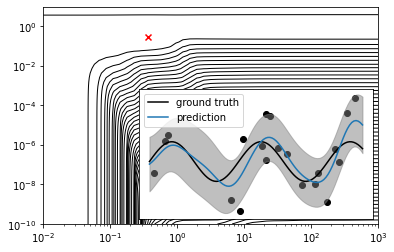

In [13]:
#fig, ax = plt.subplots(2,2, figsize=(17,10))
#plt.title('Log Marginal Likelihood Surfaces with Prediction')
for i, gp in enumerate(GPs):
    #ax = plt.subplot(2,2,i+1)
    ax = plt.subplot(1,1,1)

    plt.scatter(np.exp(gp.kernel_.theta[1]), np.exp(gp.kernel_.theta[2]), c='red', marker='x')

    a, b = gp.kernel_.bounds[1:]
    theta0 = np.linspace(a[0], a[1], 49)
    theta1 = np.linspace(b[0], b[1], 50)
    Theta0, Theta1 = np.meshgrid(theta0, theta1)
    LML = np.empty(Theta0.shape)
    for i in range(Theta0.shape[0]):
        for j in range(Theta0.shape[1]):
            try:
                LML[i,j] = gp.log_marginal_likelihood(np.array([gp.kernel_.theta[0], Theta0[i, j], Theta1[i, j]]))
            except:
                raise
                pass
    #LML = np.array(LML).T
    vmin, vmax = (-LML).min(), (-LML).max()
    level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
    plt.contour(np.exp(Theta0), np.exp(Theta1), -LML,
                levels=level, colors='black', linewidths=1., norm=LogNorm(vmin=vmin, vmax=vmax))
    plt.yscale('log')
    plt.xscale('log')
    subAx = inset_axes(ax,
                    width="70%", # width = 30% of parent_bbox
                    height="60%", # height : 1 inch
                    loc='lower right')
    subAx.plot(X_, 0.5*np.sin(3*X_), color='black', label='ground truth')
    y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
    subAx.plot(X_, y_mean, label='prediction')
    
    subAx.scatter(X, y, color='black', marker='o')
    subAx.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='grey')
    subAx.set_xticks([])
    subAx.set_xticks([], minor=True)
    subAx.set_yticks([])
    subAx.set_yticks([], minor=True)
    
    subAx.legend()
    plt.show()
#plt.savefig('data/hgdl_plot')

In [20]:
for independent in range(1):#,30,4):
    print('---------------------------------------------------------------------')
    print('---------------------------------------------------------------------')
    print('--------------------------------',independent,'-----------------------------------')
    print('---------------------------------------------------------------------')
    print('---------------------------------------------------------------------')
    
    import numpy as np

    from matplotlib import pyplot as plt
    from matplotlib.colors import LogNorm

    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, WhiteKernel
    # declare that we should use my fitting method
    from fit import fit
    GaussianProcessRegressor.fit = fit
    # generate data exactly as in the example
    rng = np.random.RandomState(0)
    X = rng.uniform(0, 5, 20)[:, np.newaxis]
    y = 0.5 * np.sin(3 * X[:, 0]) + rng.normal(0, 0.5, X.shape[0])
    print('HGDL -----------------------------------------------------------')
    kernel1 = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
        + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
    kernel2 = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
        + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))

    GPs = GaussianProcessRegressor(kernel=kernel2, alpha=0.0, optimizer='hgdl', random_state=42).fit(
        X, y, num_individuals=25, num_epochs=10, max_local=1, bestX=-1)

    for i, gp in enumerate(GPs):
        print('gp - HGDL (',i+1,'): ', gp, '\nkernel:', gp.kernel_)
        print('theta:', gp.kernel_.theta, np.exp(gp.kernel_.theta))
        print('likelihood:', gp.log_marginal_likelihood_value_)


    import numpy as np

    import matplotlib.pyplot as plt

    from matplotlib.colors import LogNorm

    rng = np.random.RandomState(0)
    X = rng.uniform(0, 5, 20)[:, np.newaxis]
    y = 0.5 * np.sin(3 * X[:, 0]) + rng.normal(0, 0.5, X.shape[0])
    X_ = np.linspace(0, 5, 100)

    GPs

    # GPs = GPs[:2] + GPs[3:]

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    #fig, ax = plt.subplots(2,2, figsize=(17,10))
    #plt.title('Log Marginal Likelihood Surfaces with Prediction')
    for i, gp in enumerate(GPs):
        #ax = plt.subplot(2,2,i+1)
        ax = plt.subplot(1,1,1)

        plt.scatter(np.exp(gp.kernel_.theta[1]), np.exp(gp.kernel_.theta[2]), c='red', marker='x')

        a, b = gp.kernel_.bounds[1:]
        theta0 = np.linspace(a[0], a[1], 49)
        theta1 = np.linspace(b[0], b[1], 50)
        Theta0, Theta1 = np.meshgrid(theta0, theta1)
        LML = np.empty(Theta0.shape)
        for j in range(Theta0.shape[0]):
            for k in range(Theta0.shape[1]):
                try:
                    LML[j,k] = gp.log_marginal_likelihood(np.array([gp.kernel_.theta[0], Theta0[j,k], Theta1[j,k]]))
                except:
                    raise
                    pass
        #LML = np.array(LML).T
        vmin, vmax = (-LML).min(), (-LML).max()
        level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
        plt.contour(np.exp(Theta0), np.exp(Theta1), -LML,
                    levels=level, colors='black', linewidths=1., norm=LogNorm(vmin=vmin, vmax=vmax))
        plt.yscale('log')
        plt.xscale('log')
        subAx = inset_axes(ax,
                        width="70%", # width = 30% of parent_bbox
                        height="60%", # height : 1 inch
                        loc='lower right')
        subAx.plot(X_, 0.5*np.sin(3*X_), color='black', label='ground truth')
        y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
        subAx.plot(X_, y_mean, label='prediction')

        subAx.scatter(X, y, color='black', marker='o')
        subAx.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                     y_mean + np.sqrt(np.diag(y_cov)),
                     alpha=0.5, color='grey')
        subAx.set_xticks([])
        subAx.set_xticks([], minor=True)
        subAx.set_yticks([])
        subAx.set_yticks([], minor=True)

        subAx.legend()
        plt.show()
    #plt.savefig('data/hgdl_plot')

---------------------------------------------------------------------
---------------------------------------------------------------------
-------------------------------- 0 -----------------------------------
---------------------------------------------------------------------
---------------------------------------------------------------------
HGDL -----------------------------------------------------------


OSError: Timed out trying to connect to 'tcp://127.0.0.1:46331' after 10 s: Timed out trying to connect to 'tcp://127.0.0.1:46331' after 10 s: connect() didn't finish in time

In [19]:
print('done')

done
